# Lesson 2 : LangGraph Components

In [1]:
# from dotenv import load_dotenv
# _ = load_dotenv()
#llama3-groq-70b-8192-tool-use-preview
import os
from langchain_groq import ChatGroq
import getpass
# KnowledgeGraphTool
import requests
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain_core.tools import tool

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"
# Load a specific environment variable
GKGraph_API_KEY = os.environ.get('GKGraph_API_KEY')
TAVILY_API_KEY=os.environ.get('TAVILY_API_KEY')
# model = ChatGroq(model="llama3-8b-8192")
model = ChatGroq(model="llama3-groq-70b-8192-tool-use-preview")

In [2]:
# !pip install -U langgraph
# !pip install langchain-community
# !pip install pygraphviz #doesn't work with windows

In [3]:
from langchain_core.tools import tool
class KnowledgeGraphTool:
    def __init__(self, api_key):
        """
        Initializes the KnowledgeGraphTool with the provided API key.

        Parameters:
        api_key (str): The API key for accessing the Google Knowledge Graph API.
        """
        self.api_key = api_key
        self.base_url = "https://kgsearch.googleapis.com/v1/entities:search"

    def search(self, query):
        """
        Sends a search request to the Google Knowledge Graph API with the given query.

        Parameters:
        query (str): The user's query to search for in the Knowledge Graph.

        Returns:
        dict: The JSON response from the API if the request is successful.
        """
        params = {
            'query': query,
            'key': self.api_key,
            'limit': 1,
            'indent': True
        }
        response = requests.get(self.base_url, params=params)
        if response.status_code == 200:
            return response.json()
        else:
            response.raise_for_status()

    def extract_info(self, response):
        """
        Extracts and returns the relevant information from the API response.

        Parameters:
        response (dict): The JSON response from the Knowledge Graph API.

        Returns:
        dict: A dictionary containing the name, description, and detailed description 
              from the response. Returns None if no relevant information is found.
        """
        if 'itemListElement' in response and len(response['itemListElement']) > 0:
            element = response['itemListElement'][0]['result']
            name = element.get('name', 'N/A')
            description = element.get('description', 'N/A')
            detailed_description = element.get('detailedDescription', {}).get('articleBody', 'N/A')
            return {
                'name': name,
                'description': description,
                'detailed_description': detailed_description
            }
        else:
            return None

def main():
    """
    The main function that handles user input, calls the search and extraction methods,
    and prints the results.
    """
    api_key = GKGraph_API_KEY
    tool = KnowledgeGraphTool(api_key)
    query = input("Enter your query: ")
    response = tool.search(query)
    info = tool.extract_info(response)
    if info:
        print(f"Name: {info['name']}")
        print(f"Description: {info['description']}")
        print(f"Detailed Description: {info['detailed_description']}")
    else:
        print("No information found.")


@tool
def google_knowledge_graph(query: str) -> str:
    """This function call google knowledge graph API that provide answer 
    for some factual questions. The Knowledge Graph allows us to answer factual questions such as “How tall is the Eiffel Tower?”
    or “Where were the 2016 Summer Olympics held.” 
    Our goal with the Knowledge Graph is for our systems to discover and surface publicly known, factual information when it’s determined to be useful.
    Args:
        query: the user prompt
    """
    prompt = ChatPromptTemplate.from_template(
    """
    Gevin this is the user question "{query}" \
    and this the answer "{answer}"\
    Act as a virual assistant and repsond like human providing the answer for the user
    """)
    llm = ChatGroq(model="llama3-groq-70b-8192-tool-use-preview")
    chain = LLMChain(llm=llm, prompt=prompt)
    api_key = GKGraph_API_KEY
    tool = KnowledgeGraphTool(api_key)
#     query = input("Enter your query: ")
    response = tool.search(query)
    info = tool.extract_info(response)
    if info:
        print(f"Name: {info['name']}")
        print(f"Description: {info['description']}")
        print(f"Detailed Description: {info['detailed_description']}")
        dictionary= {
            "name": info['name'],
            "Description":info['description'],
            "Detailed Description" :info['detailed_description']
        }
#         return  chain.run(query=query, answer=str(dictionary))
        return dictionary
    else: 
#         print("No information found.")
#         return chain.run(query=query, answer="No information found.")
        return "No information found."


# if __name__ == "__main__":
#     main()

In [4]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
# from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [5]:
tool = TavilySearchResults(max_results=2) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [6]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [7]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [8]:
# prompt = """You are a smart research assistant. Use the search engine to look up information. \
# You are allowed to make multiple calls (either together or in sequence). \
# try to look up for information when you are sure of what you want. \
# If you need to look up some information before asking a follow up question, you are allowed to do that!
# """

prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
try to find information by your self first  if you find the answer return it to the user.
then try  to use google_knowledge_graph tool if you find the answer return it to the user.
then, try tavily_search_results_json tool if you find the answer return it to the user.
if you find the answe using one if these tools, no need to use the other one
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

# model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [google_knowledge_graph,tool], system=prompt)

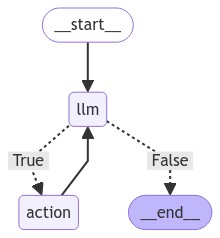

In [9]:
# from IPython.display import Image

# Image(abot.graph.get_graph().draw_png())



from IPython.display import Image, display

try:
    display(Image(abot.graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
messages = [HumanMessage(content="Hi")]
result = abot.graph.invoke({"messages": messages})

In [11]:
result

{'messages': [HumanMessage(content='Hi'),
  AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 514, 'total_tokens': 524, 'completion_time': 0.028470211, 'prompt_time': 0.038678099, 'queue_time': None, 'total_time': 0.06714831}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'stop', 'logprobs': None}, id='run-123c86eb-99e9-4b8a-aa6d-83398114c388-0', usage_metadata={'input_tokens': 514, 'output_tokens': 10, 'total_tokens': 524})]}

In [12]:
result['messages'][-1].content

'Hello! How can I assist you today?'

In [13]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

In [14]:
result['messages'][-1].content

"I'm sorry but I do not have the capability to perform this task for you, I am happy to help you with any other queries you may have."

In [15]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

# model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'who won the super bowl in 2024'}, 'id': 'call_8xzd', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'headquarters location of the winning team'}, 'id': 'call_h0g5', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': "GDP of the state where the winning team's headquarters is located"}, 'id': 'call_tes7', 'type': 'tool_call'}
Back to the model!


In [16]:
print(result['messages'][-1].content)

The winning team of the Super Bowl in 2024 is the Kansas City Chiefs. Their headquarters is located in the state of California. The GDP of California is $1.5 billion yearly revenue.


In [19]:
messages = [HumanMessage(content="what's Toronto")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Toronto'}, 'id': 'call_cma6', 'type': 'tool_call'}
Back to the model!


In [21]:
print(result['messages'][-1].content)

Toronto is Canada's largest city, the fourth largest in North America, and home to a diverse population of more than three million people. It's located on the northwestern shore of Lake Ontario, which forms part of the border between Canada and the United States. This strategic location has made Toronto an important international trading centre. The city has various neighborhoods such as Rosedale, the Annex, Cabbagetown, and the St. Lawrence Market neighborhood, each with its own unique character and history.


In [22]:
messages = [HumanMessage(content="what's Tim Hortons")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Tim Hortons'}, 'id': 'call_wdbt', 'type': 'tool_call'}
Back to the model!


In [23]:
print(result['messages'][-1].content)

Tim Hortons is a Canadian multinational fast-food restaurant chain that specializes in coffee, donuts, and other baked goods. It was founded in 1964 by Canadian hockey player Tim Horton and has since expanded to become one of the largest fast-food chains in Canada. The company is known for its iconic double-double coffee and has become a cultural fixture in Canada. It has also expanded to the United States and other countries.
